In [1]:
import sys
sys.path.append("/workdir/unsupervised_pretrain/")

In [2]:
import torch
from tqdm.notebook import tqdm
import numpy as np
from models import SeriesResNet18, Hat
from datasets import SeriesEmbedDataset

# Get ready to do some business #

In [3]:
ds = SeriesEmbedDataset(["/datasets/datasets/unsupervised-sentinel2/testset-16SEF/"], size=512, series_length=20)

In [4]:
device = torch.device("cuda")

# Load the test set, compute embeddings, save embeddings #

This only needs to be done once.

In [ ]:
model = torch.load("/workdir/unsupervised_pretrain/model.pth", map_location=device).to(device)

In [ ]:
hat = torch.load("/workdir/unsupervised_pretrain/hat.pth", map_location=device).to(device)

In [ ]:
visual_embeddings = []
v2t_embeddings = []
ds_embeddings = []
with torch.inference_mode():
    for i in tqdm(range(0, len(ds), 2)):
        imagery, _, ds_embedding = ds[i]
        imagery = torch.unsqueeze(imagery.to(device), dim=0)
        visual_embedding = model(imagery)
        v2t_embedding = hat(visual_embedding)

        visual_embedding = visual_embedding.detach().cpu()
        v2t_embedding = v2t_embedding.detach().cpu()
        ds_embedding = ds_embedding.reshape(1,-1)

        visual_embeddings.append(visual_embedding)
        v2t_embeddings.append(v2t_embedding)
        ds_embeddings.append(ds_embedding)

In [ ]:
ds_embeddings = np.concatenate(ds_embeddings, axis=0)

In [ ]:
np.save("/workdir/unsupervised_pretrain/jupyter/ds-embeddings.npy", ds_embeddings)

In [ ]:
visual_embeddings = torch.cat(visual_embeddings, dim=0).numpy()

In [ ]:
np.save("/workdir/unsupervised_pretrain/jupyter/visual-embeddings.npy", visual_embeddings)

In [ ]:
v2t_embeddings = torch.cat(v2t_embeddings, dim=0).numpy()

In [ ]:
np.save("/workdir/unsupervised_pretrain/jupyter/v2t-embeddings.npy", v2t_embeddings)

# Load embeddings #

In [5]:
ds_embeddings = np.load("/workdir/unsupervised_pretrain/jupyter/ds-embeddings.npy")
ds_embeddings /= np.linalg.norm(ds_embeddings, axis=1, keepdims=True)

In [6]:
visual_embeddings = np.load("/workdir/unsupervised_pretrain/jupyter/visual-embeddings.npy")
visual_embeddings /= np.linalg.norm(visual_embeddings, axis=1, keepdims=True)

In [7]:
v2t_embeddings = np.load("/workdir/unsupervised_pretrain/jupyter/v2t-embeddings.npy")
v2t_embeddings /= np.linalg.norm(v2t_embeddings, axis=1, keepdims=True)

In [8]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

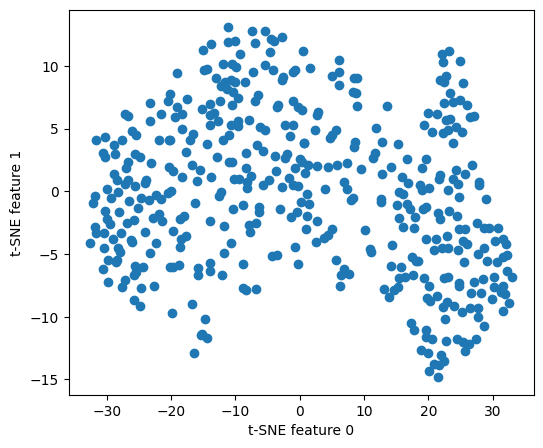

In [9]:
tsne = TSNE(n_components=2, random_state=0)

data_2d = tsne.fit_transform(visual_embeddings)

# plot the result
plt.figure(figsize=(6, 5))
plt.scatter(data_2d[:, 0], data_2d[:, 1])
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")
plt.show()

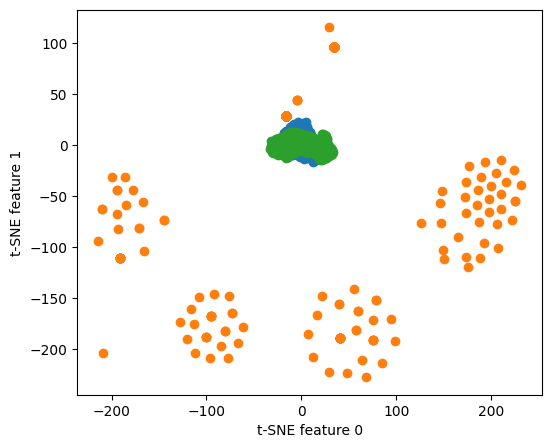

In [10]:
tsne = TSNE(n_components=2, random_state=0)

data_2d1 = tsne.fit_transform(v2t_embeddings)
data_2d2 = tsne.fit_transform(ds_embeddings)
data_2d3 = tsne.fit_transform(visual_embeddings)

# plot the result
plt.figure(figsize=(6, 5))
plt.scatter(data_2d1[:, 0], data_2d1[:, 1])
plt.scatter(data_2d2[:, 0], data_2d2[:, 1])
plt.scatter(data_2d3[:, 0], data_2d3[:, 1])
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")
plt.show()

In [11]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

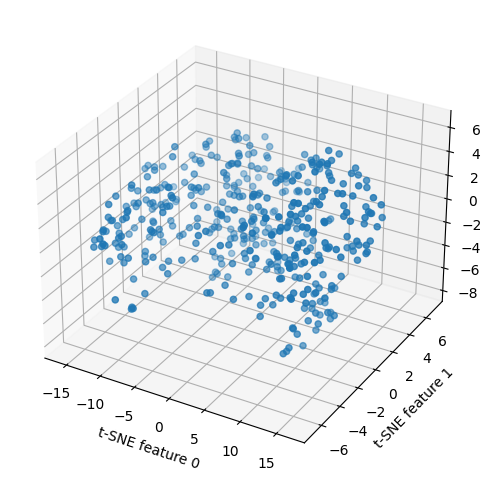

In [14]:
tsne3 = TSNE(n_components=3, random_state=0)

data_3d = tsne3.fit_transform(visual_embeddings)

# create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# plot the result
scatter = ax.scatter(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2])
ax.set_xlabel('t-SNE feature 0')
ax.set_ylabel('t-SNE feature 1')
ax.set_zlabel('t-SNE feature 2')
plt.show()

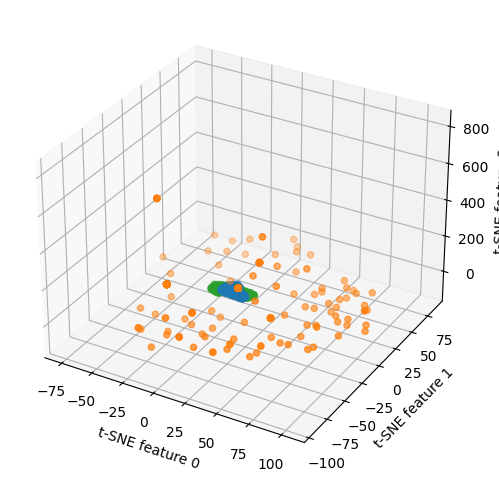

In [16]:
tsne3 = TSNE(n_components=3, random_state=0)

data_3d1 = tsne3.fit_transform(v2t_embeddings)
data_3d2 = tsne3.fit_transform(ds_embeddings)
data_3d3 = tsne3.fit_transform(visual_embeddings)

# create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# plot the result
scatter = ax.scatter(data_3d1[:, 0], data_3d1[:, 1], data_3d1[:, 2])
scatter = ax.scatter(data_3d2[:, 0], data_3d2[:, 1], data_3d2[:, 2])
scatter = ax.scatter(data_3d3[:, 0], data_3d3[:, 1], data_3d3[:, 2])
ax.set_xlabel('t-SNE feature 0')
ax.set_ylabel('t-SNE feature 1')
ax.set_zlabel('t-SNE feature 2')
plt.show()

# Look for similarity #

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
from scipy import spatial
import numpy as np
import matplotlib.pyplot as plt

## Utility functions ##

In [18]:
def top_k_query_cosine(query_vector, data, k):
    # calculate cosine similarities
    cosine_similarities = cosine_similarity(data, query_vector.reshape(1, -1)).flatten()

    # get top-k indices
    top_k_indices = np.argpartition(-cosine_similarities, k)[:k]
    
    # return indices of the top-k closest vectors
    return top_k_indices

In [19]:
def top_k_query_l1(query_vector, data, k):
    # calculate L1 distances
    l1_distances = cdist(data, query_vector.reshape(1, -1), 'cityblock').flatten()

    # get top-k indices
    top_k_indices = np.argpartition(l1_distances, k)[:k]
    
    # return indices of the top-k closest vectors
    return top_k_indices

In [20]:
def top_k_query_l2(query_vector, data, k):
    # calculate L2 distances
    l1_distances = cdist(data, query_vector.reshape(1, -1), 'euclidean').flatten()

    # get top-k indices
    top_k_indices = np.argpartition(l1_distances, k)[:k]
    
    # return indices of the top-k closest vectors
    return top_k_indices

In [21]:
def display_image(images, image_number):
    # Check that image_number is valid
    if image_number < 0 or image_number >= images.shape[0]:
        raise ValueError('image_number must be between 0 and the number of images')

    # Get the RGB bands (adjusting for 1-based indexing)
    r = images[image_number, 3, :, :] # Red band
    g = images[image_number, 2, :, :] # Green band
    b = images[image_number, 1, :, :] # Blue band

    # Stack them along the last dimension to create an RGB image
    rgb = np.stack([r, g, b], axis=-1)

    # Clamp and scale to [0, 255] range for display
    rgb = np.clip(rgb, 0, 2500)  # Ensure values are within 0-2500
    rgb = (rgb / 2500) * 255  # Scale values to 0-255

    # Convert to 8-bit unsigned integer type
    rgb = rgb.astype(np.uint8)

    # Show the image
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb)
    plt.axis('off')  # Hide the axes
    plt.show()

In [22]:
def display_all_images(images):
    # Determine the grid size to accommodate all images
    grid_size = int(np.ceil(np.sqrt(images.shape[0])))

    fig, ax = plt.subplots(grid_size, grid_size, figsize=(12, 12))

    for i in range(grid_size * grid_size):
        if i < images.shape[0]:
            # Get the RGB bands (adjusting for 1-based indexing)
            r = images[i, 3, :, :]  # Red band
            g = images[i, 2, :, :]  # Green band
            b = images[i, 1, :, :]  # Blue band

            # Stack them along the last dimension to create an RGB image
            rgb = np.stack([r, g, b], axis=-1)

            # Clamp and scale to [0, 255] range for display
            rgb = np.clip(rgb, 0, 2500)  # Ensure values are within 0-2500
            rgb = (rgb / 2500) * 255  # Scale values to 0-255

            # Convert to 8-bit unsigned integer type
            rgb = rgb.astype(np.uint8)

            # Display the image
            ax[i // grid_size, i % grid_size].imshow(rgb)
            ax[i // grid_size, i % grid_size].axis('off')  # Hide the axes
        else:
            # Hide empty subplots
            ax[i // grid_size, i % grid_size].axis('off')

    plt.show()

## Visual-visual queries ##

In [24]:
query_vector = visual_embeddings[333]
print(top_k_query_cosine(query_vector, visual_embeddings, 5))
print(top_k_query_l1(query_vector, visual_embeddings, 5))
print(top_k_query_l2(query_vector, visual_embeddings, 5))

[333 313 291 332 304]
[333 313 304 332 371]
[333 313 291 332 304]


In [26]:
images_this, _, _ = ds[333*2]
images_this = images_this.detach().cpu().numpy()

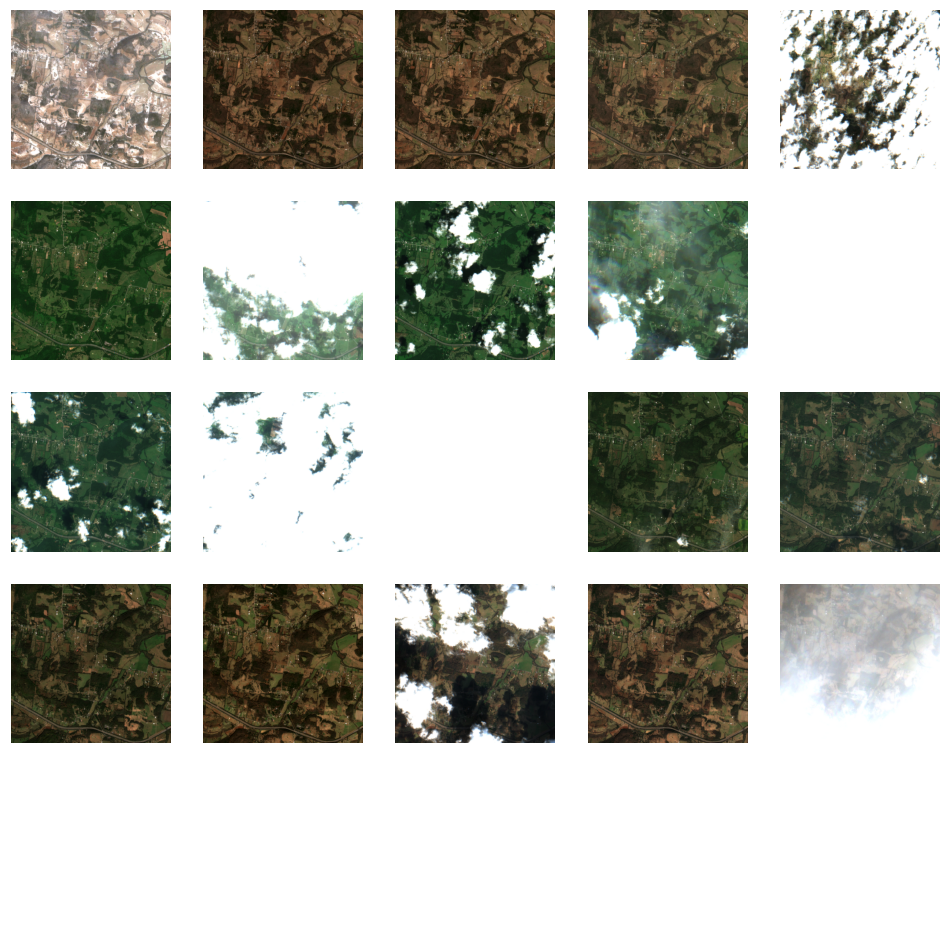

In [27]:
display_all_images(images_this)

In [28]:
images_neighbor, _, _ = ds[313*2]
images_neighbor = images_neighbor.detach().cpu().numpy()

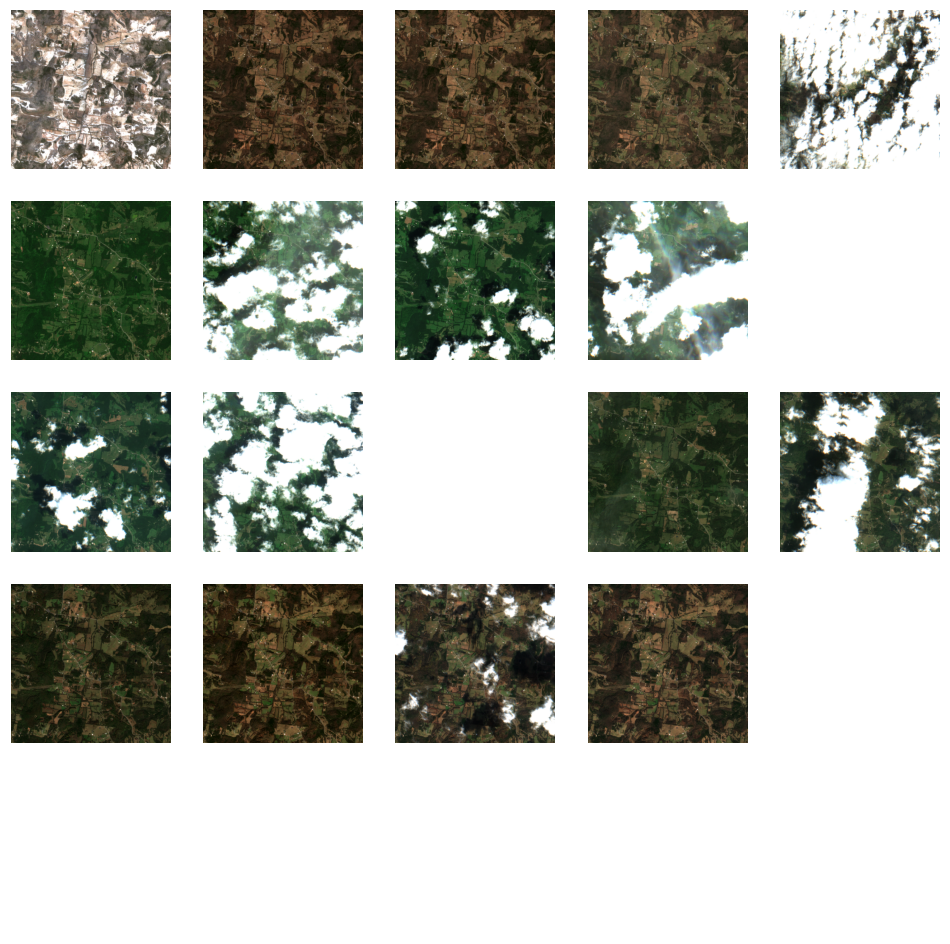

In [29]:
display_all_images(images_neighbor)

## Derived-text, derived-text queries ##

In [30]:
query_vector = v2t_embeddings[333]
print(top_k_query_cosine(query_vector, v2t_embeddings, 5))
print(top_k_query_l1(query_vector, v2t_embeddings, 5))
print(top_k_query_l2(query_vector, v2t_embeddings, 5))

[333 332 291 222 272]
[222 332 291 333 272]
[333 332 291 222 272]


In [32]:
images_neighbor, _, _ = ds[291*2]
images_neighbor = images_neighbor.detach().cpu().numpy()

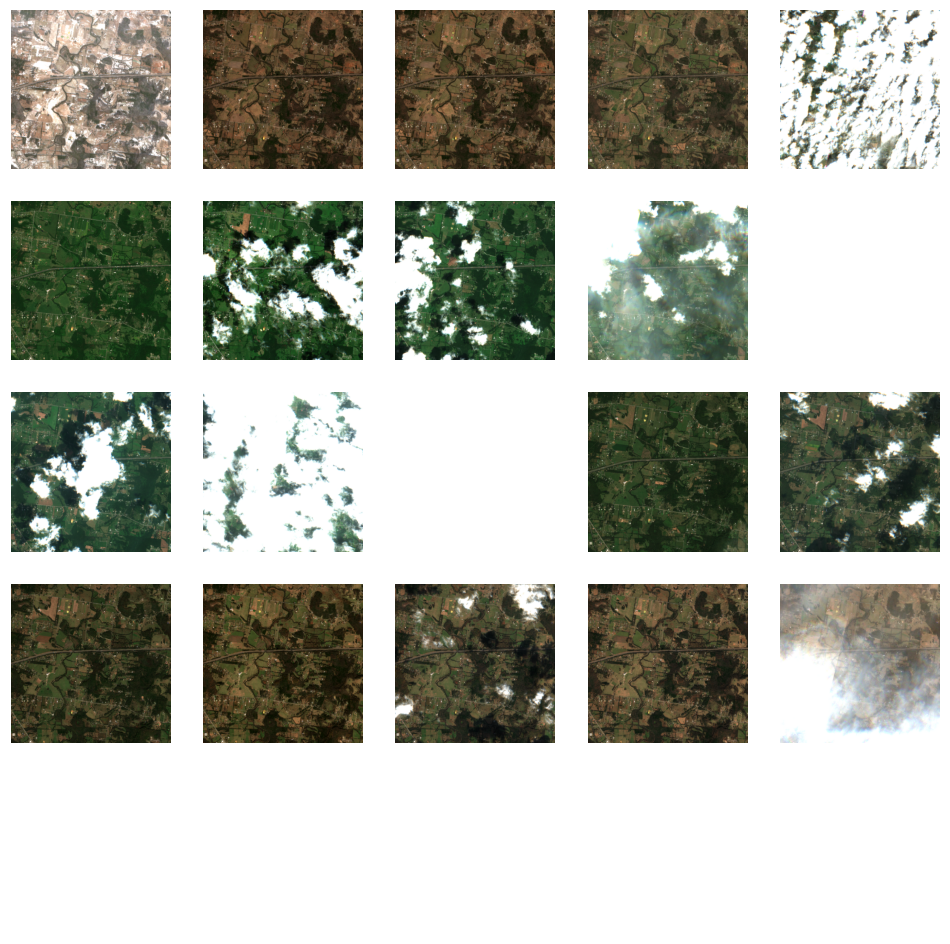

In [33]:
display_all_images(images_neighbor)

## Neighborhood similarity ##

In [34]:
def neighborhood_similarity(embeddings1, embeddings2, fn, k):
    intersections = []
    for embedding1, embedding2 in zip(embeddings1, embeddings2):
        neighborhood1 = set(fn(embedding1, embeddings1, k))
        neighborhood2 = set(fn(embedding2, embeddings2, k))
        intersections.append(len(neighborhood1 & neighborhood2))
    return (np.mean(intersections) - 1) / (k - 1)

In [40]:
neighborhood_similarity(visual_embeddings, v2t_embeddings, top_k_query_cosine, 4)

0.2758881330309902

In [41]:
cosine_overlap = []
l1_overlap = []
for i in tqdm(range(2, 32)):
    # Don't Hassle Me I'm Local
    cosine_overlap.append(neighborhood_similarity(visual_embeddings, v2t_embeddings, top_k_query_cosine, i))
    l1_overlap.append(neighborhood_similarity(visual_embeddings, v2t_embeddings, top_k_query_l1, i))

  0%|          | 0/30 [00:00<?, ?it/s]

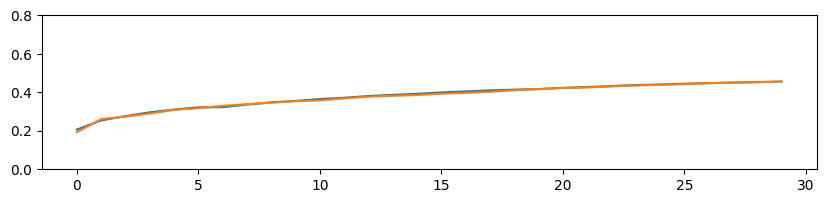

In [42]:
plt.figure(figsize=(10, 2))
plt.plot(cosine_overlap)
plt.plot(l1_overlap)
plt.yticks([i * .20 for i in range(0, 5)])
plt.show()

## Text queries ##

In [ ]:
from InstructorEmbedding import INSTRUCTOR
embed_model = INSTRUCTOR("hkunlp/instructor-xl").to(device)
embed_model.max_seq_length = 4096

## Query 1 ##

In [ ]:
instruction = "Represent the geospatial data (the number, proportion, and description of geographic features) for clustering:"
text_query = "There are zero buildings in the scene."

In [ ]:
text_query_embedding = embed_model.encode([[instruction, text_query]])
text_query_embedding /= np.linalg.norm(text_query_embedding, keepdims=True)

In [ ]:
print(top_k_query_cosine(text_query_embedding, embeddings_text_numpy, 2))
# print(top_k_query_l1(text_query_embedding, embeddings_text_numpy, 2))
# print(top_k_query_l2(text_query_embedding, embeddings_text_numpy, 2))

In [ ]:
images_this, _, _, _ = ds[363*2]
images_this = images_this.detach().cpu().numpy()
display_all_images(images_this)

## Query 2 ##

In [ ]:
text_query = "There are many buildings in the scene."
text_query_embedding = embed_model.encode([[instruction, text_query]])
text_query_embedding /= np.linalg.norm(text_query_embedding, keepdims=True)
print(top_k_query_cosine(text_query_embedding, embeddings_text_numpy, 2))

In [ ]:
images_this, _, _, _ = ds[47*2]
images_this = images_this.detach().cpu().numpy()
display_all_images(images_this)

## Query 3 ##

In [ ]:
text_query = "There are a plethora of buildings in the scene."
text_query_embedding = embed_model.encode([[instruction, text_query]])
text_query_embedding /= np.linalg.norm(text_query_embedding, keepdims=True)
print(top_k_query_cosine(text_query_embedding, embeddings_text_numpy, 2))

In [ ]:
images_this, _, _, _ = ds[44*2]
images_this = images_this.detach().cpu().numpy()
display_all_images(images_this)

## Sensitivity to quantity ##

In [ ]:
text_query = "There are a few buildings in the scene. There is water area that occupies 0% of the visible area."
text_query_embedding = embed_model.encode([[instruction, text_query]])
text_query_embedding /= np.linalg.norm(text_query_embedding, keepdims=True)
print(top_k_query_cosine(text_query_embedding, embeddings_text_numpy, 5))

In [ ]:
text_query = "There are a few buildings in the scene. There is water area that occupies 100% of the visible area."
text_query_embedding = embed_model.encode([[instruction, text_query]])
text_query_embedding /= np.linalg.norm(text_query_embedding, keepdims=True)
print(top_k_query_cosine(text_query_embedding, embeddings_text_numpy, 5))

In [ ]:
images_this, _, _, _ = ds[61*2]
images_this = images_this.detach().cpu().numpy()
display_all_images(images_this)

In [ ]:
display_image(images_this, 1)

## Sensitivity to phrasing ##

In [ ]:
text_query = "There are a few buildings in the scene. There is water area that occupies 50% of the visible area."
text_query_embedding = embed_model.encode([[instruction, text_query]])
text_query_embedding /= np.linalg.norm(text_query_embedding, keepdims=True)
phrasing1 = top_k_query_cosine(text_query_embedding, embeddings_text_numpy, 10)
print(phrasing1)

In [ ]:
text_query = "There are a few buildings visible. There is water area that occupies 50% of the visible area."
text_query_embedding = embed_model.encode([[instruction, text_query]])
text_query_embedding /= np.linalg.norm(text_query_embedding, keepdims=True)
phrasing2 = top_k_query_cosine(text_query_embedding, embeddings_text_numpy, 10)
print(phrasing2)

In [ ]:
print(set(phrasing1) & set(phrasing2))

In [ ]:
images_this, _, _, _ = ds[39*2]
images_this = images_this.detach().cpu().numpy()
display_all_images(images_this)

In [ ]:
display_image(images_this, 1)

## "Classifier" ##

### Buildings ###

In [ ]:
plural_nouns = ["zero", "a handful of", "a few", "many", "numerous", "a plethora"]
number_of_buildings = []
for plural_noun in plural_nouns:
    phrase = f"There are {plural_noun} buildings in the scene"
    phrase_embedding = embed_model.encode([[instruction, phrase]])
    number_of_buildings.append(phrase_embedding)
number_of_buildings = np.concatenate(number_of_buildings, axis=0)
number_of_buildings /= np.linalg.norm(number_of_buildings, keepdims=True, axis=1)

In [ ]:
images_this, _, _, _ = ds[(19 + 3*21)*2]
images_this = images_this.detach().cpu().numpy()
display_all_images(images_this)

In [ ]:
np.dot(number_of_buildings, embeddings_text_numpy[19 + 3*21])

In [ ]:
np.dot(number_of_buildings, embeddings_text_numpy[0])

### Land use ###

In [ ]:
lulcs = ["wood", "water", "farmland", "residential", "industrial"]
land_uses = []
for lulc in lulcs:
    phrase = f"There is {lulc} area that occupies 25% of the visible area."
    phrase_embedding = embed_model.encode([[instruction, phrase]])
    land_uses.append(phrase_embedding)
land_uses = np.concatenate(land_uses, axis=0)
land_uses /= np.linalg.norm(land_uses, keepdims=True, axis=1)

In [ ]:
np.dot(land_uses, embeddings_text_numpy[0])

In [ ]:
np.dot(land_uses, embeddings_text_numpy[-1])

In [ ]:
np.dot(land_uses, embeddings_text_numpy[19 + 3*21])